# Multimodal Factorization Model - CMU-MOSI Dataset

In [ ]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Emotion-Recognition

In [3]:
import gdown

file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=b3a5a284-5167-4300-bb90-16b24278cf48
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:02<00:00, 170MB/s]


'mosi_raw.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import MLP
from unimodals.MVAE import TSEncoder, TSDecoder
from unimodals.modules import Sequential2
from objectives import MFM_objective
from training.supervised import train, test
from fusions.modules import Concat
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
classes = 2
n_latent = 256
dim_0 = 35
dim_1 = 74
dim_2 = 300
timestep = 50
train_data, valid_data, test_data = get_dataloader(
    "/content/mosi_raw.pkl",
    task="classification",
    max_pad=True,
    max_seq_len=timestep,
)

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [9]:
encoders = [
    TSEncoder(dim_0, 30, n_latent, timestep, returnvar=False).to(device),
    TSEncoder(dim_1, 30, n_latent, timestep, returnvar=False).to(device),
    TSEncoder(dim_2, 30, n_latent, timestep, returnvar=False).to(device),
]

decoders = [
    TSDecoder(dim_0, n_latent, timestep).to(device),
    TSDecoder(dim_1, n_latent, timestep).to(device),
    TSDecoder(dim_2, n_latent, timestep).to(device),
]

fuse = Sequential2(Concat(), MLP(3 * n_latent, n_latent, n_latent // 2)).to(
    device
)

intermediates = [
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
    MLP(n_latent, n_latent // 2, n_latent // 2).to(device),
]

head = MLP(n_latent // 2, 20, classes).to(device)

argsdict = {"decoders": decoders, "intermediates": intermediates}

additional_modules = decoders + intermediates

objective = MFM_objective(
    2.0,
    [torch.nn.MSELoss(), torch.nn.MSELoss(), torch.nn.MSELoss()],
    [1.0, 1.0, 1.0],
)

## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = "MOSI_Multimodal_Factorization_Model"

train_losses, valid_losses = train(
    encoders,
    fuse,
    head,
    train_data,
    valid_data,
    200,
    additional_modules,
    objective=objective,
    objective_args_dict=argsdict,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
)

Epoch [1/200]
Train Loss: 124.2646
Valid Loss: 117.9833 | Accuracy: 56.5421%
Saving Best

Epoch [2/200]
Train Loss: 97.5552
Valid Loss: 72.9575 | Accuracy: 41.5888%

Epoch [3/200]
Train Loss: 79.1626
Valid Loss: 73.6959 | Accuracy: 56.0748%

Epoch [4/200]
Train Loss: 67.7497
Valid Loss: 58.0520 | Accuracy: 57.4766%
Saving Best

Epoch [5/200]
Train Loss: 60.9906
Valid Loss: 51.3566 | Accuracy: 57.4766%

Epoch [6/200]
Train Loss: 83.2653
Valid Loss: 81.3025 | Accuracy: 56.0748%

Epoch [7/200]
Train Loss: 66.9481
Valid Loss: 45.1641 | Accuracy: 57.4766%

Epoch [8/200]
Train Loss: 57.7014
Valid Loss: 274.5485 | Accuracy: 57.4766%

Epoch [9/200]
Train Loss: 65.7160
Valid Loss: 51.3004 | Accuracy: 57.4766%

Epoch [10/200]
Train Loss: 63.5779
Valid Loss: 49.5896 | Accuracy: 57.4766%

Epoch [11/200]
Train Loss: 41.1579
Valid Loss: 30.6919 | Accuracy: 57.4766%

Epoch [12/200]
Train Loss: 40.5561
Valid Loss: 86.2369 | Accuracy: 57.4766%

Epoch [13/200]
Train Loss: 44.0995
Valid Loss: 30.4675 | A

Text(0.5, 1.0, 'Loss vs. No. of epochs')

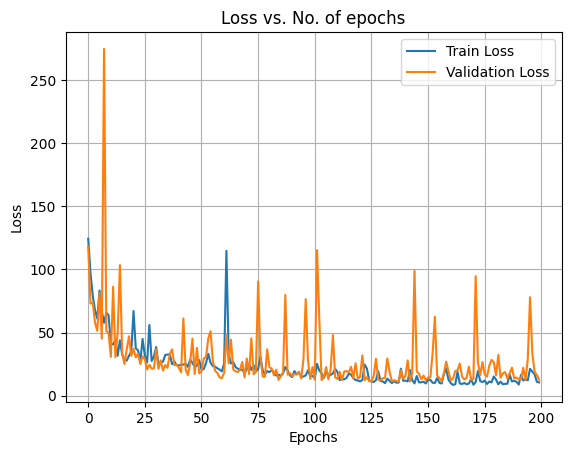

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [12]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [13]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=False
)


<ipython-input-13-3168f98e0adc>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Accuracy: 63.7026%
Inference Time: 245ms
Inference Params: 1430600
